**CNN classificaiton task on CIFAR-10 dataset Analysis**

In [25]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.profiler import profile, record_function, ProfilerActivity


In [53]:
# Data Preparation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./tmp/data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./tmp/data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, conv_config, pool_type, dropout_rate, flip_kernel, sparsity=0.0,
                 use_tiled=False, use_unshared=False, use_locally_connected=False, padding_style='same'):
        super(CustomCNN, self).__init__()
        self.layers = nn.ModuleList()
        self.flip_kernel = flip_kernel
        self.sparsity = sparsity
        self.use_tiled = use_tiled
        self.use_unshared = use_unshared
        self.use_locally_connected = use_locally_connected
        self.padding_style = padding_style

        input_channels = 3
        for out_channels, kernel_size, stride, padding in conv_config:
            if self.use_tiled:
                self.layers.append(self.create_tiled_conv(input_channels, out_channels, kernel_size, stride, padding))
            elif self.use_unshared:
                self.layers.append(self.create_unshared_conv(input_channels, out_channels, kernel_size))
            elif self.use_locally_connected:
                self.layers.append(self.create_locally_connected(input_channels, out_channels, kernel_size, stride, padding))
            else:
                self.layers.append(nn.Conv2d(input_channels, out_channels, kernel_size, stride, 0))  
            input_channels = out_channels

        self.pool_type = pool_type
        flattened_size = self.get_flattened_size((3, 32, 32))  
        self.fc1 = nn.Linear(flattened_size, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def compute_padding(self, kernel_size, stride, input_size, padding_style):
        if padding_style == 'valid':
            return 0
        elif padding_style == 'same':
            return ((input_size - 1) * stride + kernel_size - input_size) // 2
        elif padding_style == 'full':
            return kernel_size - 1
        else:
            raise ValueError(f"Unknown padding style: {padding_style}")

    def create_tiled_conv(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom tiled convolution implementation
        return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)  
    def create_unshared_conv(self, in_channels, out_channels, kernel_size):
        # Custom unshared convolution using nn.Unfold and nn.Linear
        return nn.Sequential(
            nn.Unfold(kernel_size),
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
        )

    def create_locally_connected(self, in_channels, out_channels, kernel_size, stride, padding):
        # Custom locally connected layer implementation
        height, width = 32, 32  
        output_height = (height + 2 * padding - kernel_size) // stride + 1
        output_width = (width + 2 * padding - kernel_size) // stride + 1
        return nn.ModuleList([
            nn.Linear(kernel_size * kernel_size * in_channels, out_channels)
            for _ in range(output_height * output_width)
        ])

    def get_flattened_size(self, input_shape):
        x = torch.zeros(1, *input_shape)
        with torch.no_grad():
            for conv in self.layers:
                x = F.relu(self.custom_conv(conv, x))
                x = self.pool_type(x)
        return x.numel()

    def custom_conv(self, conv, x):
        if isinstance(conv, nn.ModuleList):  
            output = []
            patches = F.unfold(x, kernel_size=3, stride=1).transpose(1, 2)  
            for i, layer in enumerate(conv):
                output.append(layer(patches[:, i]))
            return torch.stack(output, dim=1).view(x.size(0), -1, x.size(2) - 2, x.size(3) - 2)
        elif isinstance(conv, nn.Sequential):  
            return conv(x)
        else: 
            kernel_size = conv.kernel_size[0]
            stride = conv.stride[0]
            input_size = x.shape[-1]
            padding = self.compute_padding(kernel_size, stride, input_size, self.padding_style)

            if self.flip_kernel:
               
                return F.conv2d(x, conv.weight, bias=conv.bias, stride=conv.stride, padding=padding)
            else:
                
                weight = conv.weight
                flipped_weight = torch.flip(weight, dims=[2, 3])  
                return F.conv2d(x, flipped_weight, bias=conv.bias, stride=conv.stride, padding=padding)

    def apply_sparsity(self, weight):
        if self.sparsity > 0.0:
            mask = torch.rand_like(weight) > self.sparsity
            weight = weight * mask.float()  
        return weight

    def forward(self, x):
        for conv in self.layers:
            if hasattr(conv, 'weight'):
                conv.weight.data = self.apply_sparsity(conv.weight.data)
            x = F.relu(self.custom_conv(conv, x))
            x = self.pool_type(x)
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [28]:
# Function to Calculate Model Parameters and FLOPs
def calculate_params_and_flops(model, input_shape):
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())

    # Count FLOPs
    dummy_input = torch.zeros(1, *input_shape)
    with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
        with record_function("model_inference"):
            model(dummy_input)
    
    flops = sum([event.count for event in prof.key_averages()])
    return total_params, flops


In [48]:
# Training and Evaluation Function
def train_and_evaluate(conv_config, pool_type, dropout_rate, flip_kernel, sparsity, 
                        use_tiled, use_unshared, use_locally_connected, padding_style,
                        train_loader, test_loader, epochs=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize model with all the additional parameters
    model = CustomCNN(
        conv_config, 
        pool_type, 
        dropout_rate, 
        flip_kernel, 
        sparsity, 
        use_tiled, 
        use_unshared, 
        use_locally_connected, 
        padding_style
    ).to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Calculate Parameters and FLOPs
    total_params, flops = calculate_params_and_flops(model, (3, 32, 32)) 
    print(f"Total Parameters: {total_params}, FLOPs: {flops}")

    # Training Loop
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)  
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
    
    # Evaluation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)  
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    print(f"Test Accuracy: {accuracy:.2f}%")
    
    # Return accuracy, parameters, and FLOPs
    return accuracy, total_params, flops, model


Running Experiment 1/12...
Total Parameters: 768506, FLOPs: 104


STAGE:2025-01-09 23:36:01 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-09 23:36:01 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-09 23:36:01 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.5862616446926772
Epoch 2/3, Loss: 1.2029750702326254
Epoch 3/3, Loss: 1.0446197663426704
Test Accuracy: 65.31%
Running Experiment 2/12...
Total Parameters: 827622, FLOPs: 87


STAGE:2025-01-09 23:42:06 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-09 23:42:06 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-09 23:42:06 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.6268580539147262
Epoch 2/3, Loss: 1.3628473059295694
Epoch 3/3, Loss: 1.2505482992400294
Test Accuracy: 57.68%
Running Experiment 3/12...
Total Parameters: 3324282, FLOPs: 87


STAGE:2025-01-09 23:44:33 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-09 23:44:33 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-09 23:44:33 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.4261960178385
Epoch 2/3, Loss: 1.0697057996412067
Epoch 3/3, Loss: 0.8975490311832379
Test Accuracy: 66.62%
Running Experiment 4/12...
Total Parameters: 6724842, FLOPs: 87


STAGE:2025-01-09 23:50:57 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-09 23:50:57 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-09 23:50:57 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.3852480577538386
Epoch 2/3, Loss: 1.025236034027451
Epoch 3/3, Loss: 0.8588863469831779
Test Accuracy: 68.47%
Running Experiment 5/12...
Total Parameters: 3324282, FLOPs: 87


STAGE:2025-01-10 00:05:06 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:05:06 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:05:06 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.3871718562015183
Epoch 2/3, Loss: 0.9949681865589698
Epoch 3/3, Loss: 0.8138973941202359
Test Accuracy: 69.00%
Running Experiment 6/12...
Total Parameters: 3324282, FLOPs: 129


STAGE:2025-01-10 00:11:26 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:11:26 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:11:26 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 2.3032638950421074
Epoch 2/3, Loss: 2.3028344226920088
Epoch 3/3, Loss: 2.3027439099138656
Test Accuracy: 10.00%
Running Experiment 7/12...
Total Parameters: 3324282, FLOPs: 75


STAGE:2025-01-10 00:19:30 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:19:30 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:19:30 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.4239060528138106
Epoch 2/3, Loss: 1.0513870913506773
Epoch 3/3, Loss: 0.8771316015811832
Test Accuracy: 68.23%
Running Experiment 8/12...
Total Parameters: 3324282, FLOPs: 117


STAGE:2025-01-10 00:25:32 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:25:32 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:25:32 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 2.302919117386079
Epoch 2/3, Loss: 2.3027653011214704
Epoch 3/3, Loss: 2.302726534931251
Test Accuracy: 10.00%
Running Experiment 9/12...
Total Parameters: 3324282, FLOPs: 75


STAGE:2025-01-10 00:33:01 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:33:01 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:33:01 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.448013251013768
Epoch 2/3, Loss: 1.0767322639979975
Epoch 3/3, Loss: 0.912654593320149
Test Accuracy: 68.77%
Running Experiment 10/12...
Total Parameters: 2491210, FLOPs: 114


STAGE:2025-01-10 00:38:56 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:38:56 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:38:56 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.4940414917286096
Epoch 2/3, Loss: 1.0838042088710438
Epoch 3/3, Loss: 0.8983534811555273
Test Accuracy: 70.18%
Running Experiment 11/12...
Total Parameters: 3324282, FLOPs: 84


STAGE:2025-01-10 00:51:32 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:51:32 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:51:32 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 1.4917656932493
Epoch 2/3, Loss: 1.165674789558591
Epoch 3/3, Loss: 1.0012442593074515
Test Accuracy: 64.97%
Running Experiment 12/12...
Total Parameters: 3324282, FLOPs: 114


STAGE:2025-01-10 00:57:34 1628:12883 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
STAGE:2025-01-10 00:57:34 1628:12883 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2025-01-10 00:57:34 1628:12883 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


Epoch 1/3, Loss: 2.053918268979358
Epoch 2/3, Loss: 2.0063157313315156
Epoch 3/3, Loss: 1.9781376170685223
Test Accuracy: 10.50%


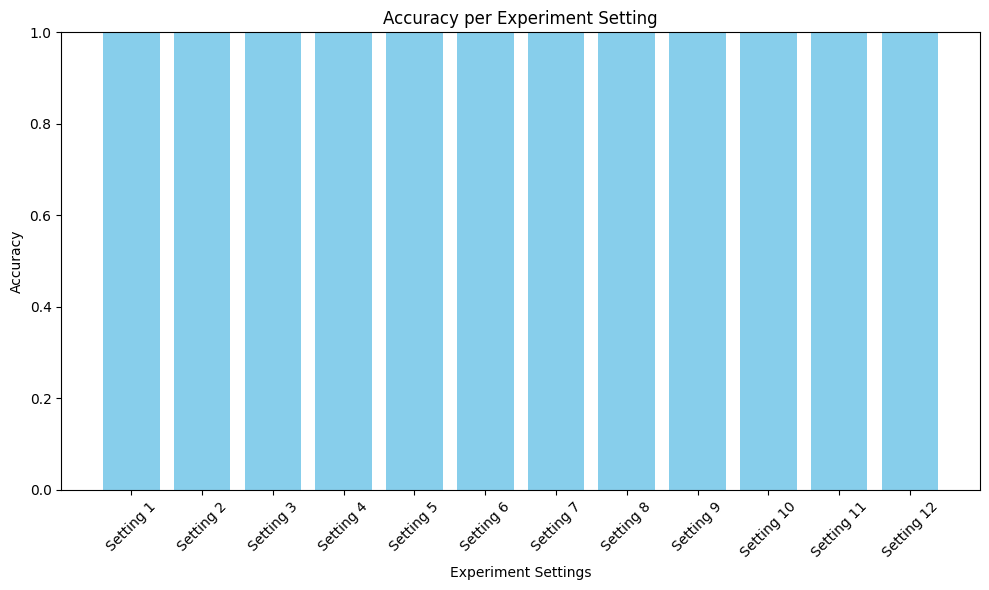

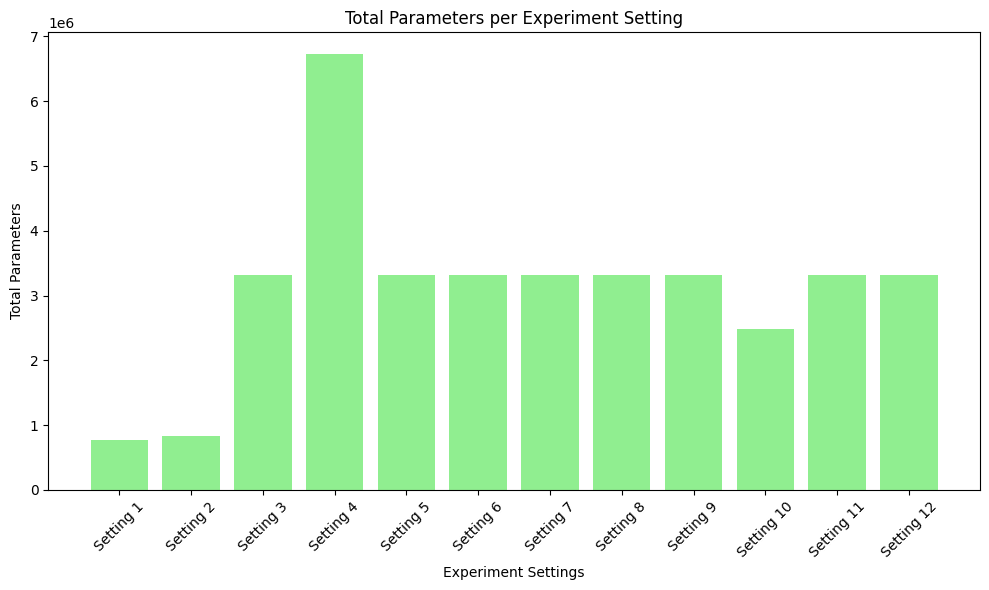

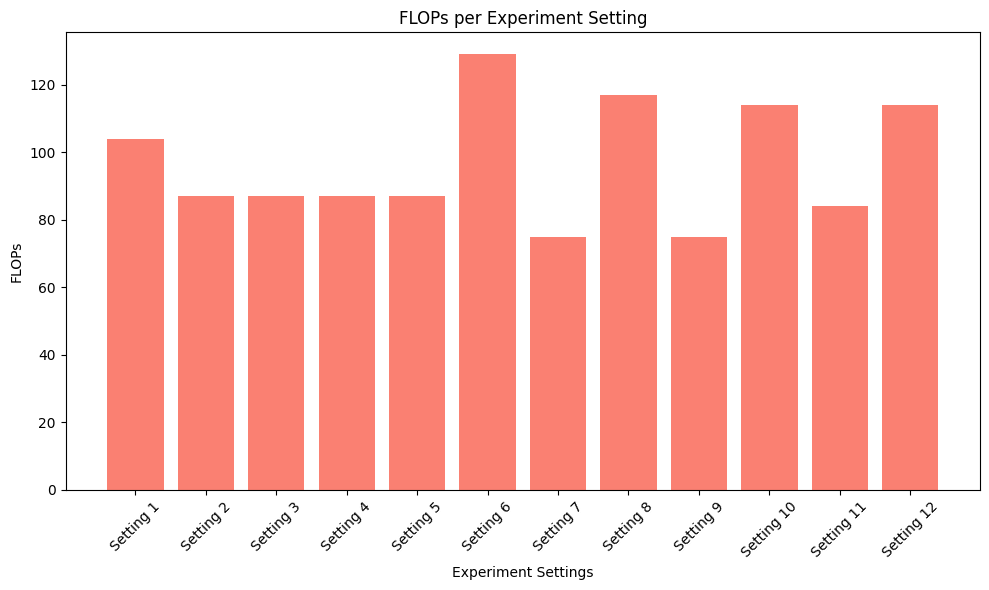

In [67]:
# Experiment Settings
settings = [
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1),(128,4,2,1)] , "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(4, 4, 1, 1), (8, 4, 1, 1), (16, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(32, 4, 1, 1), (64, 4, 1, 1), (128, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.1, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.4, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": True, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": True, "sparsity": 0.3, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": True, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": True, "padding_style": "valid"},
    {"conv_config": [(32, 3, 1, 1), (64, 3, 1, 1), (128, 3, 2, 1),(256, 3, 2, 1)], "pool_type": nn.MaxPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.AvgPool2d(kernel_size=2, stride=1), "dropout_rate": 0.3, "flip_kernel": False, "sparsity": 0.0, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
    {"conv_config": [(16, 4, 1, 1), (32, 4, 1, 1), (64, 4, 2, 1)], "pool_type": nn.AvgPool2d(kernel_size=2, stride=1), "dropout_rate": 0.1, "flip_kernel": True, "sparsity": 0.1, "use_tiled": True, "use_unshared": False, "use_locally_connected": False, "padding_style": "valid"},
   
]

# Run Experiments and Store Results
results = []
for i, setting in enumerate(settings):
    print(f"Running Experiment {i+1}/{len(settings)}...")

    # Unpack the dictionary 'setting' and pass additional required arguments explicitly
    accuracy, total_params, flops ,model= train_and_evaluate(
        conv_config=setting["conv_config"],
        pool_type=setting["pool_type"],
        dropout_rate=setting["dropout_rate"],
        flip_kernel=setting["flip_kernel"],
        sparsity=setting["sparsity"],
        use_tiled=setting["use_tiled"],
        use_unshared=setting["use_unshared"],
        use_locally_connected=setting["use_locally_connected"],
        padding_style=setting["padding_style"],
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=3
)


    # Store the results
    results.append((f"Setting {i+1}", accuracy, total_params, flops))
experiment_names = [result[0] for result in results]
accuracies = [result[1] for result in results]
total_params = [result[2] for result in results]
flops = [result[3] for result in results]

# Plot Total Parameters
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, total_params, color='lightgreen')
plt.title('Total Parameters per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('Total Parameters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot FLOPs
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, flops, color='salmon')
plt.title('FLOPs per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('FLOPs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


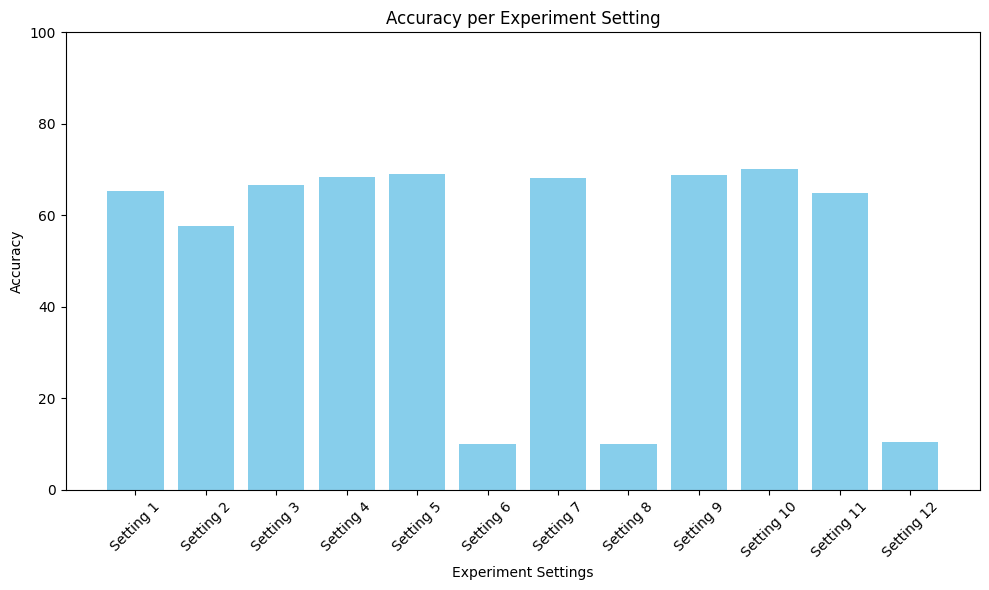

In [70]:
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, accuracies, color='skyblue')
plt.title('Accuracy per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # Assuming accuracy is in range [0, 1]
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.bar(experiment_names, accuracies, color='skyblue')
plt.title('Accuracy per Experiment Setting')
plt.xlabel('Experiment Settings')
plt.ylabel('Accuracy')
plt.ylim(0, 100)  # Assuming accuracy is in range [0, 1]
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

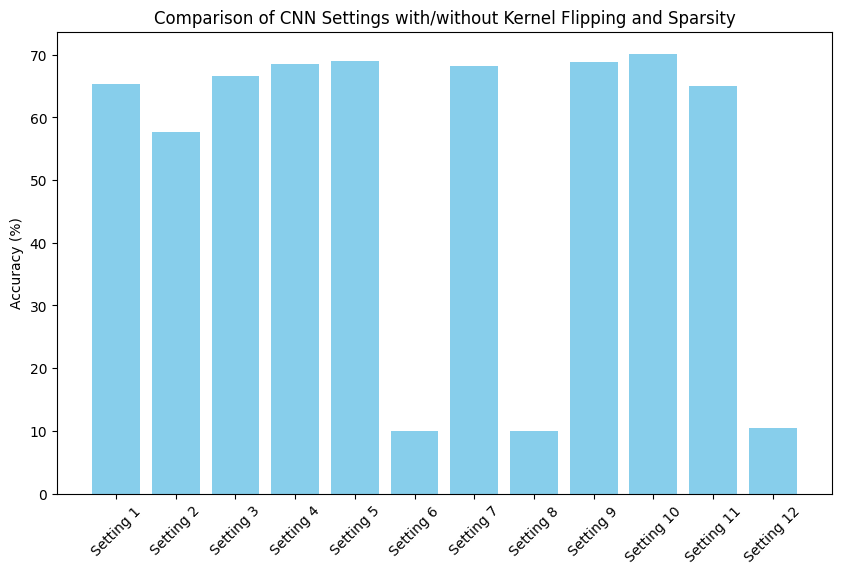

Setting 1: Accuracy = 65.31%, Params = 768506, FLOPs = 104
Setting 2: Accuracy = 57.68%, Params = 827622, FLOPs = 87
Setting 3: Accuracy = 66.62%, Params = 3324282, FLOPs = 87
Setting 4: Accuracy = 68.47%, Params = 6724842, FLOPs = 87
Setting 5: Accuracy = 69.00%, Params = 3324282, FLOPs = 87
Setting 6: Accuracy = 10.00%, Params = 3324282, FLOPs = 129
Setting 7: Accuracy = 68.23%, Params = 3324282, FLOPs = 75
Setting 8: Accuracy = 10.00%, Params = 3324282, FLOPs = 117
Setting 9: Accuracy = 68.77%, Params = 3324282, FLOPs = 75
Setting 10: Accuracy = 70.18%, Params = 2491210, FLOPs = 114
Setting 11: Accuracy = 64.97%, Params = 3324282, FLOPs = 84
Setting 12: Accuracy = 10.50%, Params = 3324282, FLOPs = 114
Visualizing predictions for Setting 1...
Visualizing predictions for Setting 2...
Visualizing predictions for Setting 3...
Visualizing predictions for Setting 4...
Visualizing predictions for Setting 5...
Visualizing predictions for Setting 6...
Visualizing predictions for Setting 7...

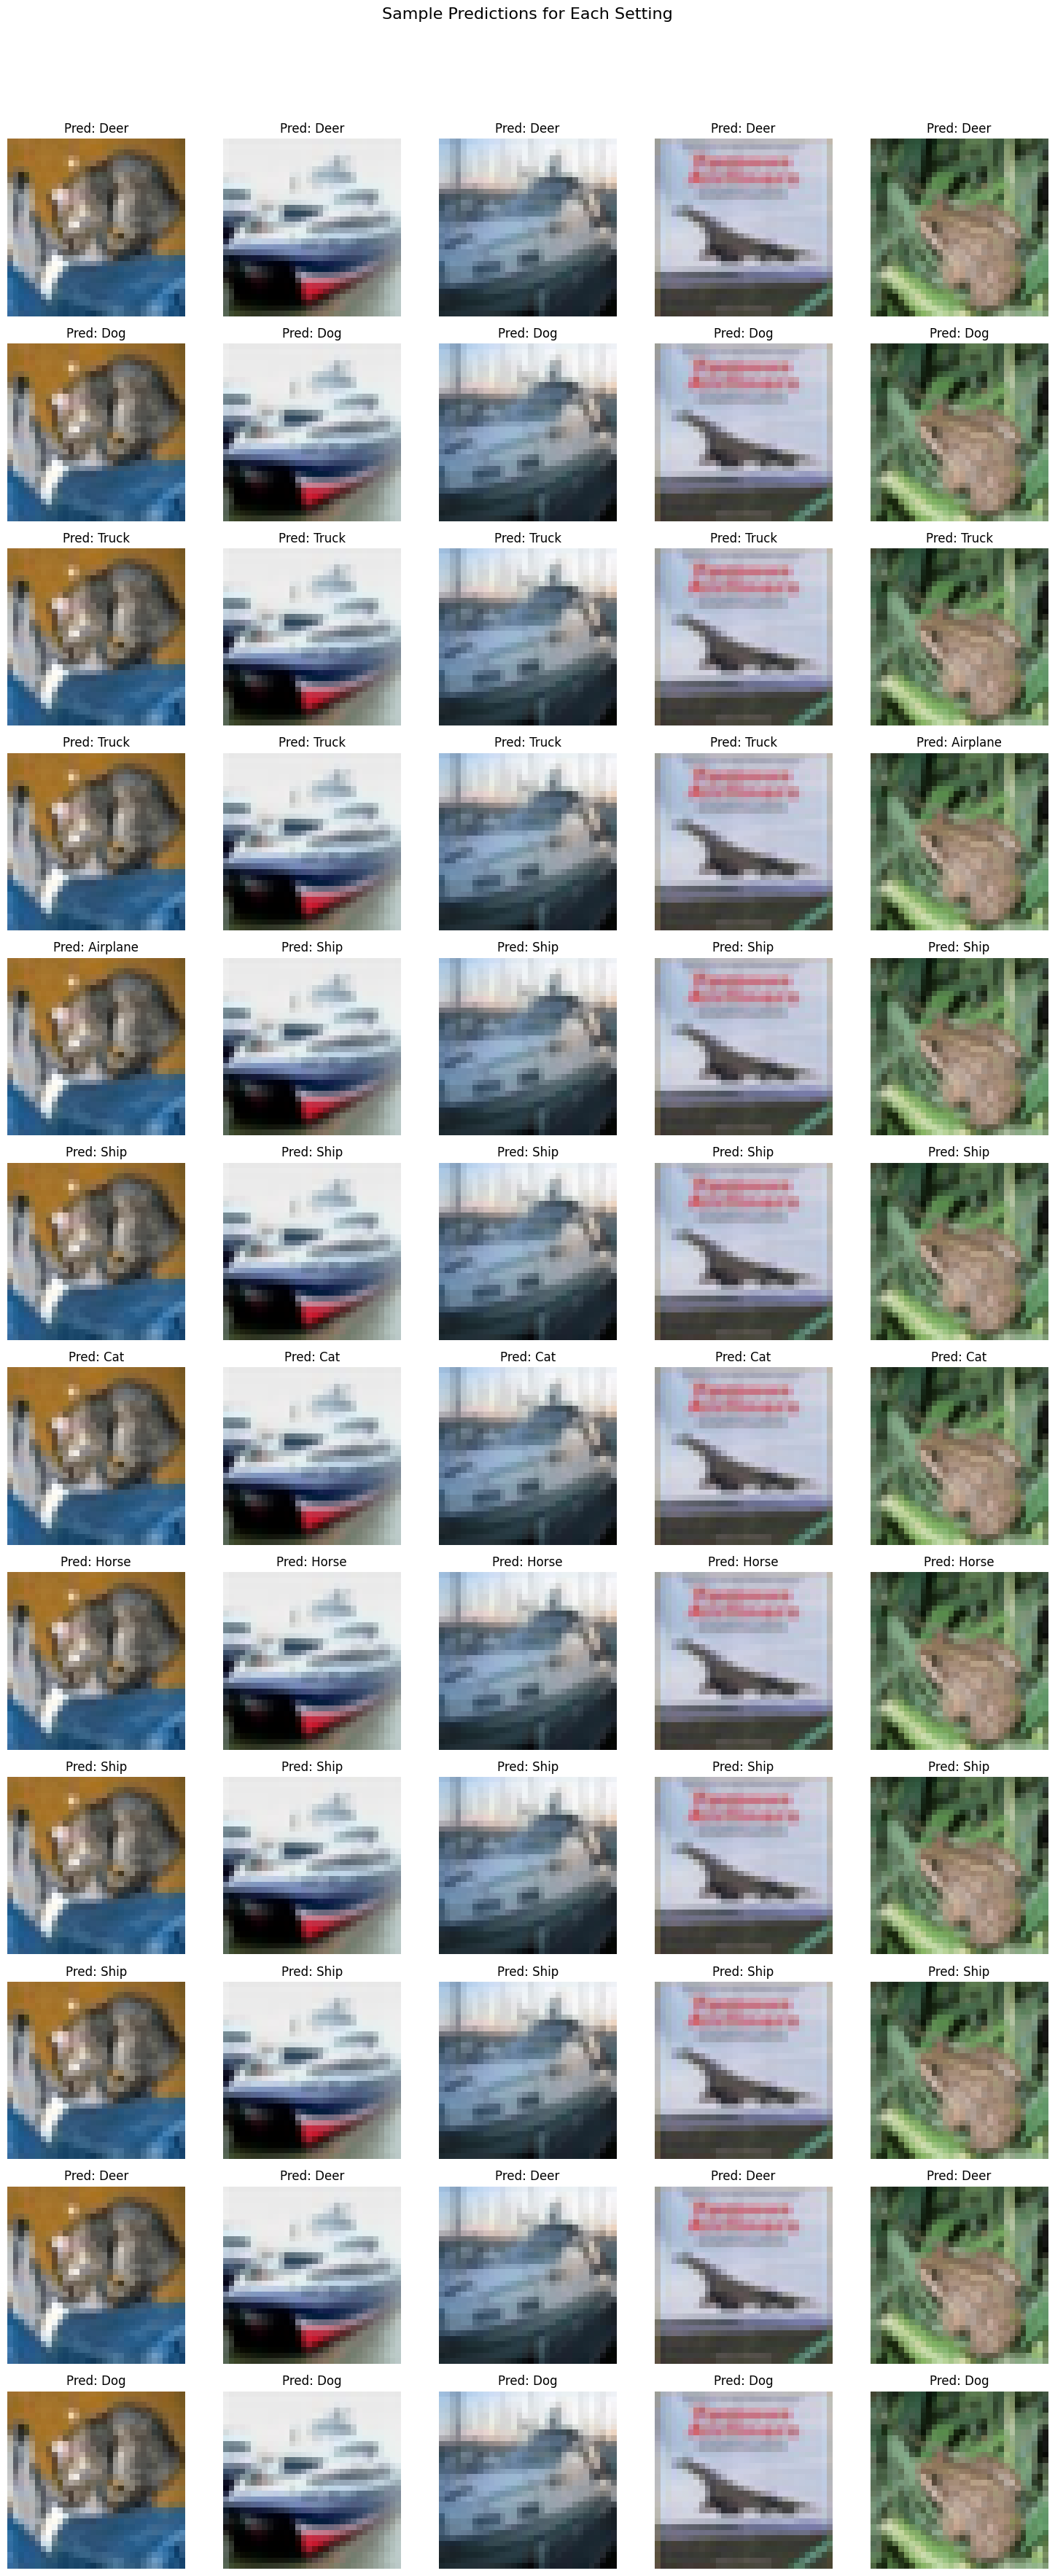

In [68]:
def visualize_results(settings, results, test_loader):
    label_mapping = {
        0:"Airplane",
        1:"Automobile",
        2:"Bird",
        3:"Cat",
        4:"Deer",
        5:"Dog",
        6:"Frog",
        7:"Horse",
        8:"Ship",
        9:"Truck"
    }
    # Plot Accuracy Results
    labels, accuracies, params, flops = zip(*results)
    plt.figure(figsize=(10, 6))
    plt.bar(labels, accuracies, color='skyblue')
    plt.ylabel("Accuracy (%)")
    plt.title("Comparison of CNN Settings with/without Kernel Flipping and Sparsity")
    plt.xticks(rotation=45)
    plt.show()

    # Display Computational Cost Results
    for i, (label, accuracy, param, flop) in enumerate(results):
        print(f"Setting {i+1}: Accuracy = {accuracy:.2f}%, Params = {param}, FLOPs = {flop}")

    # Display Predictions for Each Setting
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # Adjust the number of subplots based on settings
    fig, axs = plt.subplots(len(settings), 5, figsize=(15, len(settings) * 3))
    fig.suptitle("Sample Predictions for Each Setting", fontsize=16)

    if len(settings) == 1: 
        axs = axs.reshape(1, 5)  

    for i, setting in enumerate(settings):
        print(f"Visualizing predictions for Setting {i+1}...")
        model = CustomCNN(**setting).to(device)
        model.eval()

        samples, predictions = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                samples.extend(inputs[:5].cpu())
                predictions.extend(predicted[:5].cpu())
                break  

        # Plot the Predictions
        for j in range(5):
            axs[i, j].imshow(transforms.ToPILImage()(samples[j] * 0.5 + 0.5))
            axs[i, j].set_title(f"Pred: {label_mapping[predictions[j].item()]}")
            axs[i, j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Run Experiments and Visualize
visualize_results(settings, results, test_loader)


<Figure size 800x800 with 0 Axes>

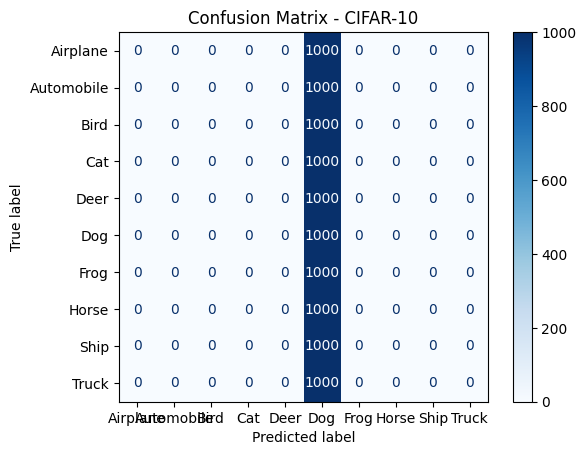

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to compute and display the confusion matrix
def compute_confusion_matrix_cifar10(model, data_loader):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data, labels in data_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # CIFAR-10 class names
    class_names = [
        "Airplane", "Automobile", "Bird", "Cat", "Deer", 
        "Dog", "Frog", "Horse", "Ship", "Truck"
    ]
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    # Display the confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix - CIFAR-10")
    plt.show()

# Example usage
compute_confusion_matrix_cifar10(model, test_loader)


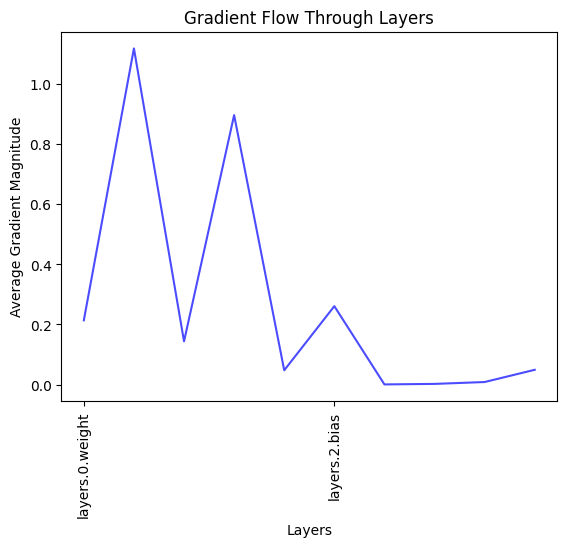

In [61]:
def plot_grad_flow(model):
    ave_grads = []
    layers = []
    for name, param in model.named_parameters():
        if param.grad is not None:
            ave_grads.append(param.grad.abs().mean().item())
            layers.append(name)
    
    plt.plot(ave_grads, alpha=0.7, color='b')
    plt.xticks(range(0, len(layers), 5), layers[::5], rotation=90)
    plt.title("Gradient Flow Through Layers")
    plt.xlabel("Layers")
    plt.ylabel("Average Gradient Magnitude")
    plt.show()


plot_grad_flow(model)

In [62]:
criterion = nn.CrossEntropyLoss()
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)  
    loss = criterion(outputs, labels)


**Edge detection task using sobel kernel**

/var/folders/2c/lq_x3ldd70x6rjfy37hff1bh0000gp/T/ipykernel_1628/3227522834.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image).unsqueeze(0)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.92941177].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9372549].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for inte

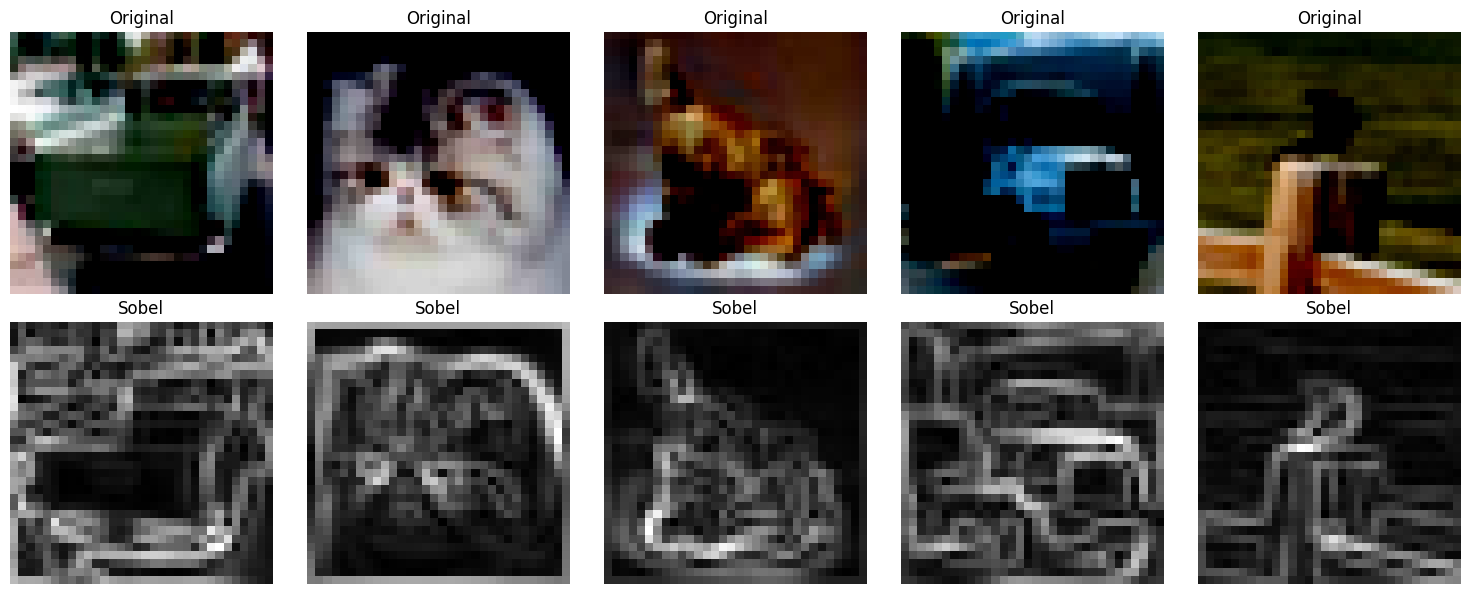

In [76]:
import numpy as np
import torch

import matplotlib.pyplot as plt
import torch.nn.functional as F

# Define Sobel kernels
sobel_kernel_x = torch.tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]], dtype=torch.float32)
sobel_kernel_y = torch.tensor([[[[-1, -2, -1], [0, 0, 0], [1, 2, 1]]]], dtype=torch.float32)

# Function to apply Sobel filter
def apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y):
    image = torch.tensor(image).unsqueeze(0)  
    if image.shape[1] == 3:  
        image = image.mean(dim=1, keepdim=True)
    sobel_x = F.conv2d(image, sobel_kernel_x, padding=1)
    sobel_y = F.conv2d(image, sobel_kernel_y, padding=1)
    sobel = torch.sqrt(sobel_x ** 2 + sobel_y ** 2)
    return sobel.squeeze(0)  

# Function to plot images
def plot_images(images, titles, rows=1, cols=5):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols] if rows > 1 else axes[i]
        ax.imshow(image.permute(1, 2, 0).numpy(), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Select some random images from the test dataset
random_indices = np.random.choice(len(test_dataset), 5, replace=False)
images = [test_dataset[i][0] for i in random_indices]

# Apply Sobel filter to the selected images
sobel_images = [apply_sobel_filter(image, sobel_kernel_x, sobel_kernel_y) for image in images]

# Plot the original and Sobel filtered images
plot_images(images + sobel_images, ['Original'] * 5 + ['Sobel'] * 5, rows=2, cols=5)